# LSTM Notebook
In this notebook we try to predict the closing price of AAPL stock using three different LSTM models:


*   Vanilla LSTM
*   Stacked LSTM
*   LSTM-GRU hybrid model
*   BiLSTM



A lenght of 90 days, namely three months is used as look-back period, to predict the next day's price.

*Potentially, there could be several other models to experiment with, however for the sake of this analysis we will only focus on these aforementioned. 




# Importing the libraries

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import io
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL.csv


# Load data

In [4]:
#Load the data
data = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']) , index_col = 'Date', parse_dates = True) 

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516528,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401018,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443573,447610800


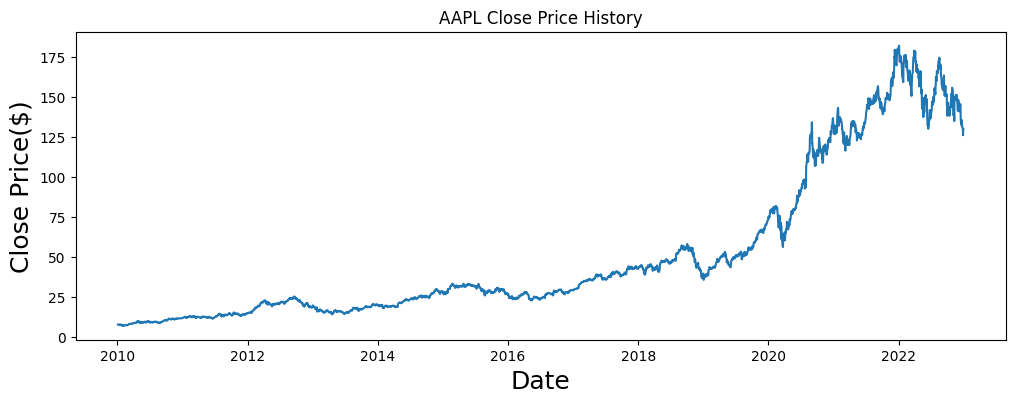

In [6]:
#Plot the data
plt.figure(figsize=(12,4))
plt.title('AAPL Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price($)', fontsize=18)
plt.show()

In [7]:
#Create new dataset filtering the closing price
data = data.filter(['Close'])
#Convert the dataset to a numpy array
dataset = data.values

In [8]:
#Define train and test sets size
training_data_len = int(np.ceil( len(dataset) * .90 ))
testing_data_len = int(len(dataset)) - training_data_len
training_data_len, testing_data_len

(2945, 327)

# Pre-processing of data

As a remark, according to some sources (not so many though), using MinMaxScaler may not be the best option as stocks' prices are not bounded quantities, therefore defining a min and a max may result in a trivial operation. Using MinMaxScaler using returns instead of the closing price may be a solution.

In [9]:
#Normalize the data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler()
scaled_data= sc.fit_transform(data)

In [10]:
scaled_data

array([[0.00447776],
       [0.00455321],
       [0.00385789],
       ...,
       [0.68044731],
       [0.70082972],
       [0.70265667]])

In [11]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 91:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

[array([4.47776321e-03, 4.55321237e-03, 3.85789259e-03, 3.77836696e-03,
       4.06383482e-03, 3.68253539e-03, 3.19519608e-03, 3.79264035e-03,
       3.54387795e-03, 2.83020830e-03, 4.68778763e-03, 4.01286167e-03,
       3.26656305e-03, 1.16225955e-03, 2.24703742e-03, 2.83224654e-03,
       3.22782506e-03, 1.47627420e-03, 2.03824052e-06, 5.46465415e-04,
       7.76877944e-04, 1.46403905e-03, 0.00000000e+00, 6.95314067e-04,
       4.22081359e-04, 8.44168428e-04, 6.25985342e-04, 1.34985190e-03,
       1.69853377e-03, 2.31432791e-03, 2.14100895e-03, 2.21849064e-03,
       1.96156956e-03, 1.70668673e-03, 1.02156387e-03, 1.75562734e-03,
       2.02886005e-03, 2.56309031e-03, 3.45416111e-03, 3.42561432e-03,
       3.52348412e-03, 3.80487550e-03, 5.48505939e-03, 5.51156794e-03,
       6.31495443e-03, 6.68606265e-03, 6.82063791e-03, 7.04493571e-03,
       6.48215866e-03, 6.60653701e-03, 6.53925224e-03, 6.64731895e-03,
       6.15794711e-03, 6.66771277e-03, 7.40380878e-03, 7.60975671e-03,
     

In [12]:
test_data = scaled_data[training_data_len - 90: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i-90:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [13]:
x_test


array([[[0.70425537],
        [0.68507187],
        [0.67970511],
        ...,
        [0.81136287],
        [0.81467431],
        [0.80650988]],

       [[0.68507187],
        [0.67970511],
        [0.66177769],
        ...,
        [0.81467431],
        [0.80650988],
        [0.81170542]],

       [[0.67970511],
        [0.66177769],
        [0.6743383 ],
        ...,
        [0.80650988],
        [0.81170542],
        [0.81033514]],

       ...,

       [[0.94010889],
        [0.91755695],
        [0.91561571],
        ...,
        [0.7157882 ],
        [0.71367577],
        [0.70322764]],

       [[0.91755695],
        [0.91561571],
        [0.91732853],
        ...,
        [0.71367577],
        [0.70322764],
        [0.68044731]],

       [[0.91561571],
        [0.91732853],
        [0.93160192],
        ...,
        [0.70322764],
        [0.68044731],
        [0.70082972]]])

# Vanilla LSTM
We start with a basic implementation of a Long-Short Term Memory model using just one LSTM layer and a dropout to remove some of the neurons from one step to the other. Adam is chosen as optimizer, together with a mean_squared_error loss function.

In [14]:
#Build a Vanilla LSTM
vanilla_lstm = Sequential()
vanilla_lstm.add(LSTM(units = 128, input_shape = (x_train.shape[1], 1)))
vanilla_lstm.add(Dropout(rate = 0.2))
vanilla_lstm.add(Dense(units = 1))
vanilla_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [15]:
#Display the structure of the LSTM
vanilla_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [16]:
vanilla_history = vanilla_lstm.fit(x_train, y_train, epochs = 20, batch_size= 16)

Epoch 1/20
179/179 [==============================] - 11s 52ms/step - loss: 0.0024
Epoch 2/20
179/179 [==============================] - 11s 59ms/step - loss: 3.7922e-04
Epoch 3/20
179/179 [==============================] - 10s 54ms/step - loss: 3.8237e-04
Epoch 4/20
179/179 [==============================] - 9s 48ms/step - loss: 3.5806e-04
Epoch 5/20
179/179 [==============================] - 10s 54ms/step - loss: 3.1475e-04
Epoch 6/20
179/179 [==============================] - 10s 54ms/step - loss: 3.6669e-04
Epoch 7/20
179/179 [==============================] - 9s 52ms/step - loss: 3.2883e-04
Epoch 8/20
179/179 [==============================] - 9s 49ms/step - loss: 3.1810e-04
Epoch 9/20
179/179 [==============================] - 9s 52ms/step - loss: 2.7415e-04
Epoch 10/20
179/179 [==============================] - 9s 53ms/step - loss: 2.9890e-04
Epoch 11/20
179/179 [==============================] - 8s 47ms/step - loss: 3.3957e-04
Epoch 12/20
179/179 [==============================

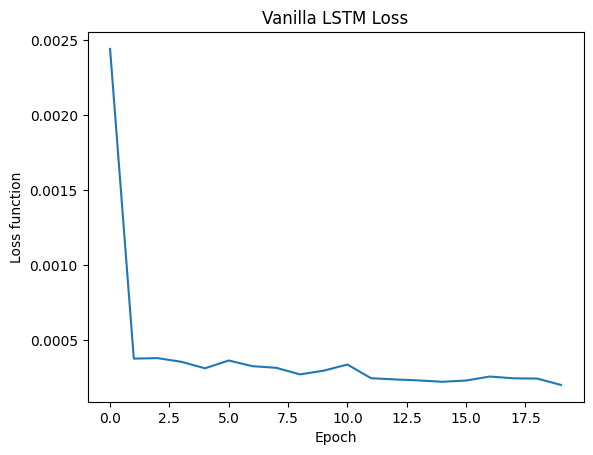

In [17]:
#Plot the loss over the epochs
plt.plot(vanilla_history.history['loss'])
plt.title('Vanilla LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.show()

In [18]:
predictions = vanilla_lstm.predict(x_test)
predictions = sc.inverse_transform(predictions)

11/11 [==============================] - 1s 25ms/step


In [19]:
mse = np.mean(((predictions - y_test) ** 2))
print("Vanilla MSE:", mse)

Vanilla MSE: 21.951395060313516


In [20]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("Vanilla RMSE:", rmse)

Vanilla RMSE: 4.685231590894255


<ipython-input-21-42146f5f4631>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Vanilla Predictions'] = predictions


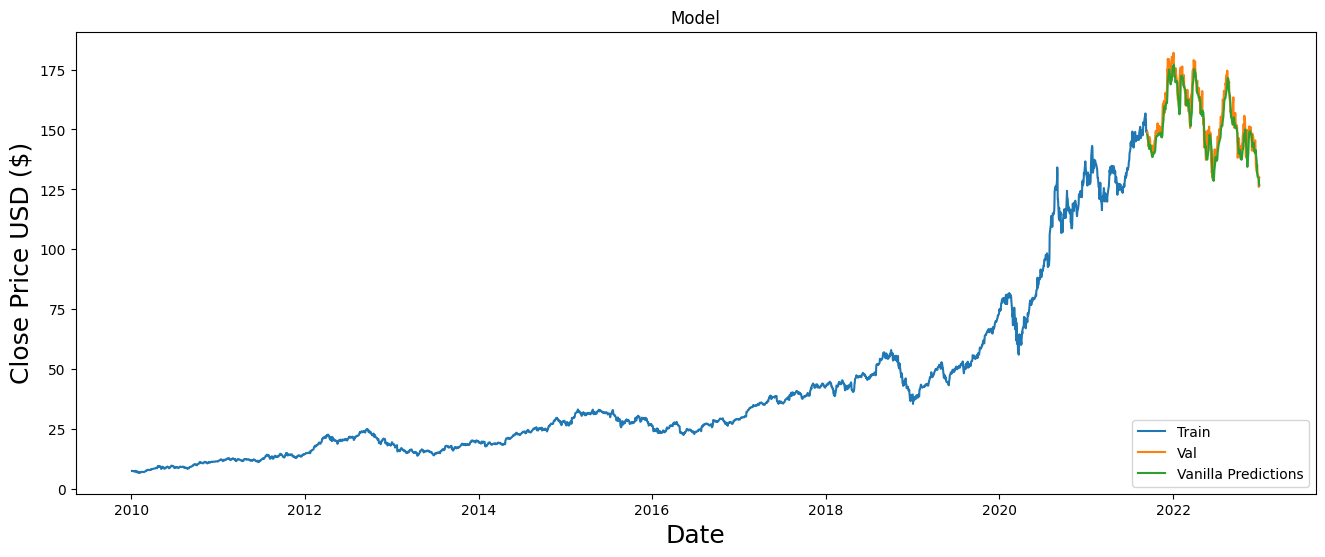

In [21]:
# Plot the data
train = data[:int(training_data_len)]
valid = data[int(training_data_len):]
valid['Vanilla Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Vanilla Predictions']])
plt.legend(['Train', 'Val', 'Vanilla Predictions'], loc='lower right')
plt.show()

In [22]:
# Vanilla predictions for the closing price
valid

,Close,Vanilla Predictions
Date,,
2021-09-15,149.029999,147.704117
2021-09-16,148.789993,146.580902
2021-09-17,146.059998,145.966461
2021-09-20,142.940002,145.014648
2021-09-21,143.429993,143.389572
...,...,...
2022-12-23,131.860001,130.230453
2022-12-27,130.029999,129.764771
2022-12-28,126.040001,129.051880


# Stacked LSTM
We implement a three-layer stacked LSTM model, using tanh, dropout rate and a final Dense layer.

In [23]:
#Build a stacked LSTM
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units = 128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
stacked_lstm.add(Dropout(rate = 0.2))
stacked_lstm.add(LSTM(units=128, return_sequences=True))
stacked_lstm.add(Dropout(rate = 0.2))
stacked_lstm.add(LSTM(units=128))
stacked_lstm.add(Dropout(rate = 0.2))
stacked_lstm.add(Dense(units = 1))
stacked_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
stacked_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 90, 128)           66560     
                                                                 
 dropout_1 (Dropout)         (None, 90, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 90, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [25]:
stacked_history = stacked_lstm.fit(x_train, y_train, epochs = 20, batch_size= 16)

Epoch 1/20
179/179 [==============================] - 40s 196ms/step - loss: 0.0022
Epoch 2/20
179/179 [==============================] - 35s 197ms/step - loss: 8.0946e-04
Epoch 3/20
179/179 [==============================] - 34s 193ms/step - loss: 7.4930e-04
Epoch 4/20
179/179 [==============================] - 35s 198ms/step - loss: 7.4351e-04
Epoch 5/20
179/179 [==============================] - 35s 196ms/step - loss: 4.9922e-04
Epoch 6/20
179/179 [==============================] - 35s 193ms/step - loss: 4.9532e-04
Epoch 7/20
179/179 [==============================] - 36s 199ms/step - loss: 5.7750e-04
Epoch 8/20
179/179 [==============================] - 35s 198ms/step - loss: 4.4414e-04
Epoch 9/20
179/179 [==============================] - 35s 193ms/step - loss: 4.9616e-04
Epoch 10/20
179/179 [==============================] - 35s 194ms/step - loss: 5.0559e-04
Epoch 11/20
179/179 [==============================] - 35s 198ms/step - loss: 4.9789e-04
Epoch 12/20
179/179 [=============

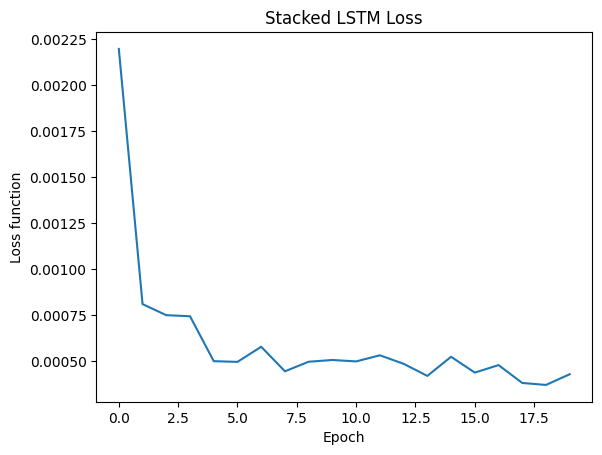

In [26]:
#Plot the loss
plt.plot(stacked_history.history['loss'])
plt.title('Stacked LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.show()

In [27]:
predictions_stacked = stacked_lstm.predict(x_test)
predictions_stacked = sc.inverse_transform(predictions_stacked)

11/11 [==============================] - 2s 86ms/step


In [28]:
#Get the rmse
rmse = np.sqrt(np.mean(((predictions_stacked - y_test) ** 2)))
rmse

9.570154836695124

# LSTM/GRU model
We combine both LSTM and GRU models into a single model to leverage advantages of both model, the idea is that LSTM may underperform whereas GRU over-predicts the price.

In [29]:
lstm_gru= Sequential()
lstm_gru.add(LSTM(units = 128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
lstm_gru.add(Dropout(rate = 0.2))
lstm_gru.add(GRU(units = 128, input_shape = (x_train.shape[1], 1)))
lstm_gru.add(Dropout(rate = 0.2))
lstm_gru.add(Dense(units = 1))
lstm_gru.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [30]:
lstm_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 90, 128)           66560     
                                                                 
 dropout_4 (Dropout)         (None, 90, 128)           0         
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm_gru_history = lstm_gru.fit(x_train, y_train, epochs = 20, batch_size = 16)

Epoch 1/20
179/179 [==============================] - 24s 117ms/step - loss: 0.0018
Epoch 2/20
179/179 [==============================] - 20s 112ms/step - loss: 5.0428e-04
Epoch 3/20
179/179 [==============================] - 21s 116ms/step - loss: 5.5695e-04
Epoch 4/20
179/179 [==============================] - 21s 115ms/step - loss: 4.5604e-04
Epoch 5/20
179/179 [==============================] - 21s 116ms/step - loss: 4.3611e-04
Epoch 6/20
179/179 [==============================] - 21s 117ms/step - loss: 4.4240e-04
Epoch 7/20
179/179 [==============================] - 20s 111ms/step - loss: 4.6409e-04
Epoch 8/20
179/179 [==============================] - 21s 117ms/step - loss: 3.9806e-04
Epoch 9/20
179/179 [==============================] - 20s 110ms/step - loss: 3.4206e-04
Epoch 10/20
179/179 [==============================] - 21s 118ms/step - loss: 3.5522e-04
Epoch 11/20
179/179 [==============================] - 21s 120ms/step - loss: 3.0065e-04
Epoch 12/20
179/179 [=============

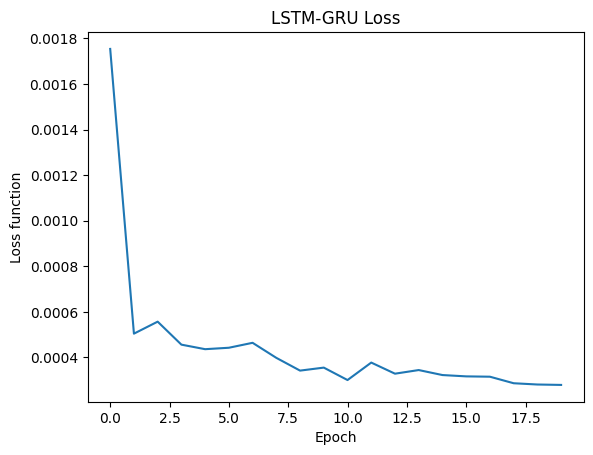

In [32]:
#Plot the loss
plt.plot(lstm_gru_history.history['loss'])
plt.title('LSTM-GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.show()

In [33]:
predictions_gru = lstm_gru.predict(x_test)
predictions_gru = sc.inverse_transform(predictions_gru)

11/11 [==============================] - 1s 41ms/step


In [34]:
#Get the rmse
rmse = np.sqrt(np.mean(((predictions_gru - y_test) ** 2)))
rmse

5.631107036840264

In [35]:
valid['Stacked Predictions'] = predictions_stacked
valid['Gru Predictions'] = predictions_gru

<ipython-input-35-1eb0ddee036e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Stacked Predictions'] = predictions_stacked
<ipython-input-35-1eb0ddee036e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Gru Predictions'] = predictions_gru


In [36]:
#Get the predictions for all the models
valid

,Close,Vanilla Predictions,Stacked Predictions,Gru Predictions
Date,,,,
2021-09-15,149.029999,147.704117,143.601807,147.049454
2021-09-16,148.789993,146.580902,142.762573,146.315491
2021-09-17,146.059998,145.966461,142.216110,145.849869
2021-09-20,142.940002,145.014648,141.528915,144.938187
2021-09-21,143.429993,143.389572,140.425507,143.386658
...,...,...,...,...
2022-12-23,131.860001,130.230453,129.273651,130.758179
2022-12-27,130.029999,129.764771,128.651138,130.023849
2022-12-28,126.040001,129.051880,127.909119,129.027191


# BiLSTM

In [37]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

bi_lstm = keras.Sequential()
bi_lstm.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
bi_lstm.add(Dropout(rate=0.2))
bi_lstm.add(Bidirectional(LSTM((128 * 2), return_sequences=True))) 
bi_lstm.add(Dropout(rate=0.2))
bi_lstm.add(Bidirectional(LSTM(128, return_sequences=False))) 
bi_lstm.add(Dense(units=1))
# linear activation function: activation is proportional to the input
bi_lstm.add(Activation('tanh'))
bi_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
bi_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 90, 128)           66560     
                                                                 
 dropout_6 (Dropout)         (None, 90, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 512)          788480    
 l)                                                              
                                                                 
 dropout_7 (Dropout)         (None, 90, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                

In [39]:
bi_lstm_history = bi_lstm.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=16,
    shuffle=False  #time series data must not be shuffled
    )

Epoch 1/10
179/179 [==============================] - 185s 992ms/step - loss: 0.0015
Epoch 2/10
179/179 [==============================] - 176s 982ms/step - loss: 0.0088
Epoch 3/10
179/179 [==============================] - 177s 992ms/step - loss: 0.0114
Epoch 4/10
179/179 [==============================] - 176s 985ms/step - loss: 0.0098
Epoch 5/10
179/179 [==============================] - 177s 988ms/step - loss: 0.0123
Epoch 6/10
179/179 [==============================] - 177s 989ms/step - loss: 0.0150
Epoch 7/10
179/179 [==============================] - 176s 983ms/step - loss: 0.0132
Epoch 8/10
179/179 [==============================] - 183s 1s/step - loss: 0.0131
Epoch 9/10
179/179 [==============================] - 184s 1s/step - loss: 0.0128
Epoch 10/10
179/179 [==============================] - 177s 986ms/step - loss: 0.0129


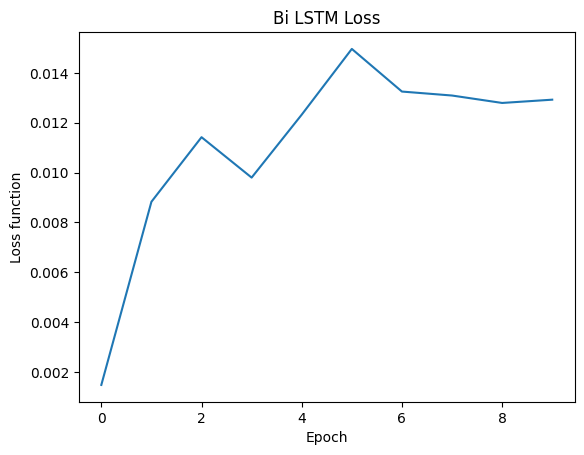

In [40]:
#Plot the loss
plt.plot(bi_lstm_history.history['loss'])
plt.title('Bi LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.show()

In [41]:
predictions_bi = bi_lstm.predict(x_test)
predictions_bi = sc.inverse_transform(predictions_bi)

11/11 [==============================] - 4s 236ms/step


In [42]:
#RMSE test set
rmse = np.sqrt(np.mean(((predictions_bi - y_test) ** 2)))
rmse

15.775967303827716

# Conclusion 
After having trained the four models, we observe that for this dataset there is some obscillation in the RMSE among them. In general, the training loss decreases over the epochs, with some minor fluctuations. Even a simple Vanilla model is able to doing relatively well in this context, with the advantage of being the least expensive.Overall the predictions are quite good, in principle one could have obtained better results but this may be due to the fact that the model has to deal with difficult predictions, since in the last year or so, there are big changes in AAPL stock price.